# LAB 9 : Time series, Anomaly detection and network data

## This notebook is a Lab made to discover how to manage in real world networks data prediction and anomaly detection. 
 >>> We decided to use a dataset call *5G3E* (https://github.com/cedric-cnam/5G3E-dataset) for this lab. However, as the dataset itself is too big (countains thousands features and >500K datapoints), we decided to use only the first several raws and directly apply a PCA to get a fast and easier computation

### The Lab is designed into 2 parts. 
- The first is to make differebnts RNN models, comparison and visualization on the 5G3E dataset
- The second is to build a classifier to detect anomalies

### I put here all the import I suggest to use. you are free to add me except for this lab no RNN etc. direct construction from keras since we wil directly construct it manually

In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score


### To load the dataset we have to download the dataset first this time as there is no direct loader, if you do it on your PC ensure you have correct path

In [ ]:
path_data="/path_to_your_train_data"

df_train=pd.read_csv(path_data)
columns_train=df_train.columns
df_train.head()

,node_context_switches_total_server_1,"node_cpu_scaling_frequency_hertz{cpu=""0""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""1""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""10""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""11""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""12""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""13""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""14""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""15""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""16""}_server_1",...,"node_softnet_processed_total{cpu=""6""}_server_6","node_softnet_processed_total{cpu=""7""}_server_6",node_timex_maxerror_seconds_server_6,node_timex_offset_seconds_server_6,node_timex_pps_shift_seconds_server_6,node_vmstat_pgpgout_server_6,process_open_fds_server_6,process_virtual_memory_bytes_server_6,promhttp_metric_handler_requests_in_flight_server_6,"promhttp_metric_handler_requests_total{code=""200""}_server_6"
0,0.000000,0.666667,0.333333,0.5,0.666667,0.054036,0.6,0.666667,0.5,0.5,...,0.07936,0.861101,0.061544,0.0,0.0,0.912306,0.0,0.447784,0.090909,0.615634
1,0.000002,0.666667,0.666667,0.5,0.333333,0.054036,0.6,0.666667,0.5,0.5,...,0.07936,0.861101,0.061544,0.0,0.0,0.912306,0.0,0.447784,0.090909,0.615634
2,0.000003,0.666667,0.666667,0.5,0.666667,0.054036,0.6,0.666667,0.5,0.5,...,0.07936,0.861101,0.061544,0.0,0.0,0.912306,0.0,0.447784,0.090909,0.615634
3,0.000005,0.666667,0.666667,0.5,0.666667,0.054036,0.6,0.666667,0.5,0.5,...,0.07936,0.861102,0.061544,0.0,0.0,0.912306,0.0,0.447784,0.090909,0.615634
4,0.000007,0.666667,0.666667,0.5,0.666667,0.054036,0.6,0.666667,0.5,0.5,...,0.07936,0.861102,0.061794,0.0,0.0,0.912306,0.0,0.447784,0.090909,0.615634


### Same for test dataset
The test dataset here is only the next 20K raws of the train. It is made to be a simple task for now.

In [ ]:
path_test="/path_to_your_test_data"
df_test=pd.read_csv(path_test)
columns_test=df_test.columns
df_test.head()

,node_context_switches_total_server_1,"node_cpu_scaling_frequency_hertz{cpu=""0""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""1""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""10""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""11""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""12""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""13""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""14""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""15""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""16""}_server_1",...,"node_softnet_processed_total{cpu=""6""}_server_6","node_softnet_processed_total{cpu=""7""}_server_6",node_timex_maxerror_seconds_server_6,node_timex_offset_seconds_server_6,node_timex_pps_shift_seconds_server_6,node_vmstat_pgpgout_server_6,process_open_fds_server_6,process_virtual_memory_bytes_server_6,promhttp_metric_handler_requests_in_flight_server_6,"promhttp_metric_handler_requests_total{code=""200""}_server_6"
0,0.034458,0.666667,0.666667,0.5,0.666667,0.054036,0.6,0.666667,0.5,0.5,...,0.080215,0.866902,0.037882,0.0,0.0,0.913665,0.0,0.447784,0.090909,0.616279
1,0.034460,0.666667,0.666667,0.5,0.666667,0.054036,0.6,0.666667,0.5,0.5,...,0.080215,0.866902,0.037882,0.0,0.0,0.913665,0.0,0.447784,0.090909,0.616279
2,0.034462,0.666667,0.666667,0.5,0.666667,0.054036,0.6,0.666667,0.5,0.5,...,0.080215,0.866903,0.038132,0.0,0.0,0.913665,0.0,0.447784,0.090909,0.616279
3,0.034463,0.666667,0.666667,0.5,0.666667,0.054036,0.6,0.666667,0.5,0.5,...,0.080215,0.866903,0.038132,0.0,0.0,0.913665,0.0,0.447784,0.090909,0.616279
4,0.034465,0.666667,0.666667,0.5,0.666667,0.054036,0.6,0.666667,0.5,0.5,...,0.080215,0.866903,0.038132,0.0,0.0,0.913665,0.0,0.447784,0.090909,0.616279


>>Try to visualize the data, how it looks like ? What can we say about the general aspect of such features ? Is there cycles, seasons etc.

>>>Apply a PCA on the dataset. Warning : normally you need to standardize the dataset before such tranformation, however, it is already done here.
Instead of selecting a percent of variance explained by the PCA, I suggest here to set a number of component (not too high to be abble to compute easily)

>>> Once we have fit the pca for the train we need to make the transform for the test (only the tranform as we cannot directly affect a test set with such tools most of the times)

>>>Try to visualize the PCs, what can you say about it ? How it looks like, can we say aything about it ?

## Let's now build the dataset for model like RNN 
we can use `torch.tensor`, `DataLoader` and `TensorDataset` for example. the idea is to create a sequence to get the next timestep each time, for this we have to set a new hyperparameter for our framework : a windo size. It will be the lenght of the sequence X before to predict

## Let's now build different models. 
>>> We can think about the 3 classicals RNN, LSTM, GRU, but if you prefer using more classical ARIMA to compare, or advanced tools as Transformers or else don't hesitate ! try at least 3 models 
For most architectures, you will need few hyperparameters as the number of features (here the output of the PCA), a number of layers etc.

model 1:

model 2

model 3

## It's time to train your models.
>>> Set your optimizer, lr, any hyperparameters of your model and watch

As the training might take some times, start short, keep the maximum information to avoid unuseful retraining

### verify your model is converging (this we can start by plotting the loss, even if itis sometimes not enough it's a good start)
compare your models

# Now it's time for evaluation...
reshape you test data accordingly (like train if it is not already done) and evaluate each models, compare them. In this part you can use `mse` or `rmse` to evaluate, or any other functions like this you think is suitable.

>>> One more times, visualization is important, try to plot your data and see how it looks like, check your predictions comapred with the target, can you improve it ?

In [ ]:
# Plot the feature == 2 for example
##comparion with ARIMA model also ?

## Try to improve results, loop training and evaluation until satisfying results...

> ---
> **Anomaly detection part**
> ---


## The point of that part is to build a simple classsifier to try to predict where are the anomalies based on the previous aprt we did. In the first part we made models to reconstruct the time series. As we trained only on normal data (we think) we can imagine that when there is an anomaly, we our score of reconstruction is less good, as there was no anomalies on the training dataset. We can try to check verify this.

### For this part, we will use the anomaly file to directly get all anomalies and a second file for the remaining columns.
Same as before, ensure you get correct path for theses files.

In [ ]:
path_data_AD="path_to_anomalies.csv"


cols = pd.read_csv(path_data_AD, nrows=0).columns
df_AN=pd.read_csv(path_data_AD, usecols=['attack'])


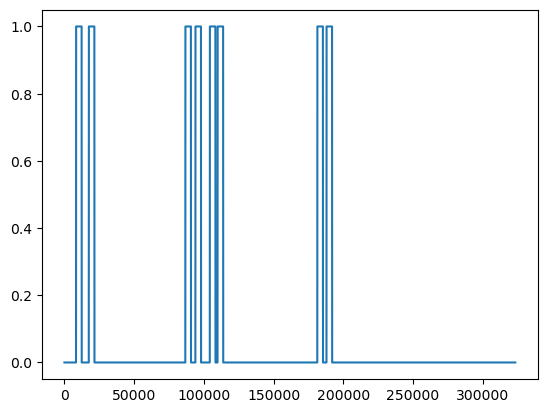

In [37]:
plt.plot(df_AN.iloc[:,0])


In [38]:
#need to check exact timeline to create enough data below with some anomalies
for k in range(len(df_AN)):
    if k>1 and df_AN.iloc[k,0]==1 and df_AN.iloc[k-1,0]==0:
        print("Anomaly detected at index:", k)
    if k>1 and df_AN.iloc[k,0]==0 and df_AN.iloc[k-1,0]==1:
        print("End of Anomaly detected at index:", k)

Anomaly detected at index: 8343
End of Anomaly detected at index: 12347
Anomaly detected at index: 17481
End of Anomaly detected at index: 21485
Anomaly detected at index: 86685
End of Anomaly detected at index: 90689
Anomaly detected at index: 93899
End of Anomaly detected at index: 97903
Anomaly detected at index: 104234
End of Anomaly detected at index: 108238
Anomaly detected at index: 109789
End of Anomaly detected at index: 113793
Anomaly detected at index: 181305
End of Anomaly detected at index: 185309
Anomaly detected at index: 187887
End of Anomaly detected at index: 191891


In [ ]:
path_data_AD_complete="/path_to_df_AN_complete_clean.csv"
df_AN_complete = pd.read_csv(path_data_AD_complete)
df_AN_complete.head()

,node_context_switches_total_server_1,"node_cpu_scaling_frequency_hertz{cpu=""0""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""1""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""10""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""11""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""12""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""13""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""14""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""15""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""16""}_server_1",...,"node_softnet_times_squeezed_total{cpu=""2""}_server_6","node_softnet_times_squeezed_total{cpu=""3""}_server_6","node_softnet_times_squeezed_total{cpu=""4""}_server_6","node_softnet_times_squeezed_total{cpu=""5""}_server_6","node_softnet_times_squeezed_total{cpu=""6""}_server_6",node_timex_pps_shift_seconds_server_6,node_timex_pps_stability_exceeded_total_server_6,process_resident_memory_bytes_server_6,process_start_time_seconds_server_6,"promhttp_metric_handler_errors_total{cause=""encoding""}_server_6"
0,0.000000,0.666667,0.666667,0.666667,0.6,0.666667,0.50,0.666667,0.6,0.666667,...,0.932857,0.000000e+00,0.000000,0.201966,0.910696,0.078890,0.0,0.998999,0.896495,0.973156
1,0.000002,0.666667,0.333333,0.666667,0.6,0.666667,0.50,0.666667,0.6,0.666667,...,0.932858,4.383731e-08,0.000003,0.201966,0.910696,0.078890,0.0,0.998999,0.896495,0.973156
2,0.000003,0.666667,0.666667,0.666667,0.6,0.666667,0.50,0.666667,0.6,0.666667,...,0.932858,1.183607e-07,0.000006,0.201966,0.910696,0.078890,0.0,0.998999,0.896495,0.973156
3,0.000005,0.666667,0.333333,0.666667,0.6,0.666667,0.25,0.666667,0.6,0.666667,...,0.932858,8.372925e-07,0.000008,0.201966,0.910696,0.079143,0.0,0.998999,0.896495,0.973156
4,0.000007,0.666667,0.333333,0.666667,0.6,0.666667,0.50,0.666667,0.6,0.666667,...,0.932858,1.508003e-06,0.000010,0.201966,0.910697,0.079143,0.0,0.998999,0.896495,0.973156


>>> Apply the same tranformation to the data, to use prediction on `df_AN_complete`

>>> Make clear evaluations and visualizations of your models on this data. Compare it with before, what can you say about ? Do you think we can get correct classifiers ?

### we cannot say from this that where there is an anomaly we can recreate less well, even if the score itself is less good in general !

Now we need to build a classifier, we need for this few tools, one to compute the error for each raws, and a Threashold function at least

Let's try to make some prediction on anomalies

In [ ]:
#An example of thresholding function can be based on percentile

In [ ]:
 # Dont forget to select relevant columns df_AN[feature_cols] (based on window size used during training)

>>> Now we need to evaluate the classifier. Classical tools are actually not the best for time series, neither on anomaly detection. However, they are eay to use, and simple enough for a short lesson, so you can start by using precision, recall, F1 score for example.

## The last thing : you have to reach at least 98% on F1 score !

## As we can see here, we are capable of very good performance even with basic classifier based on reconstruction loss

### If we want to improve even further, we can now set up ensemble learning ...

>>> # End of Lab 9, and of all Labs, See you at the exams...